# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [2]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## CIFAR-10 Data Loading and Preprocessing

In [3]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000L, 32L, 32L, 3L)
Training labels shape:  (50000L,)
Test data shape:  (10000L, 32L, 32L, 3L)
Test labels shape:  (10000L,)


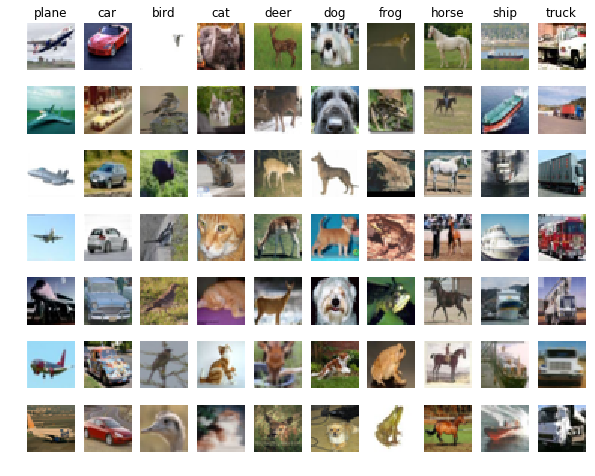

In [4]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000L, 32L, 32L, 3L)
Train labels shape:  (49000L,)
Validation data shape:  (1000L, 32L, 32L, 3L)
Validation labels shape:  (1000L,)
Test data shape:  (1000L, 32L, 32L, 3L)
Test labels shape:  (1000L,)


In [6]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000L, 3072L)
Validation data shape:  (1000L, 3072L)
Test data shape:  (1000L, 3072L)
dev data shape:  (500L, 3072L)


[ 130.64189796  135.98173469  132.47391837  130.05569388  135.34804082
  131.75402041  130.96055102  136.14328571  132.47636735  131.48467347]


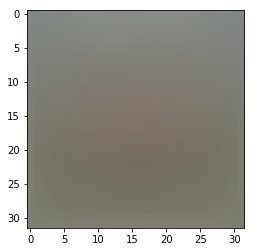

In [7]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [8]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [9]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000L, 3073L) (1000L, 3073L) (1000L, 3073L) (500L, 3073L)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [14]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.531359


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [18]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 13.007880 analytic: 13.007880, relative error: 8.721408e-12
numerical: -29.438415 analytic: -29.438415, relative error: 1.529137e-11
numerical: -50.414854 analytic: -50.414854, relative error: 1.212077e-14
numerical: 8.396320 analytic: 8.396320, relative error: 5.032287e-11
numerical: -34.028294 analytic: -34.028294, relative error: 9.231150e-12
numerical: -6.091933 analytic: -6.091933, relative error: 4.599494e-11
numerical: -43.945406 analytic: -43.945406, relative error: 1.999914e-12
numerical: 37.775834 analytic: 37.663717, relative error: 1.486191e-03
numerical: 16.248112 analytic: 16.248112, relative error: 1.007317e-11
numerical: 3.597083 analytic: 3.684053, relative error: 1.194458e-02
numerical: -14.204910 analytic: -14.204910, relative error: 5.461972e-12
numerical: 23.593968 analytic: 23.593968, relative error: 2.500154e-11
numerical: -18.086198 analytic: -18.086198, relative error: 3.054522e-12
numerical: -9.484517 analytic: -9.422049, relative error: 3.304046e-0

In [25]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 1.053136e+01 computed in 0.115000s
Vectorized loss: 1.053136e+01 computed in 0.004000s
difference: 0.000000


In [26]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.087000s
Vectorized loss and gradient: computed in 0.016000s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [59]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=3000, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 3000: loss 785.641439
iteration 100 / 3000: loss 287.314996
iteration 200 / 3000: loss 108.560076
iteration 300 / 3000: loss 43.929387
iteration 400 / 3000: loss 19.742744
iteration 500 / 3000: loss 11.185695
iteration 600 / 3000: loss 8.291906
iteration 700 / 3000: loss 7.534570
iteration 800 / 3000: loss 6.548826
iteration 900 / 3000: loss 6.181868
iteration 1000 / 3000: loss 6.731736
iteration 1100 / 3000: loss 6.035077
iteration 1200 / 3000: loss 6.123966
iteration 1300 / 3000: loss 6.111906
iteration 1400 / 3000: loss 6.106465
iteration 1500 / 3000: loss 6.442699
iteration 1600 / 3000: loss 6.269104
iteration 1700 / 3000: loss 6.462883
iteration 1800 / 3000: loss 6.301627
iteration 1900 / 3000: loss 6.589698
iteration 2000 / 3000: loss 6.410753
iteration 2100 / 3000: loss 6.231694
iteration 2200 / 3000: loss 5.795421
iteration 2300 / 3000: loss 6.194652
iteration 2400 / 3000: loss 6.300344
iteration 2500 / 3000: loss 6.440970
iteration 2600 / 3000: loss 6.985264
iter

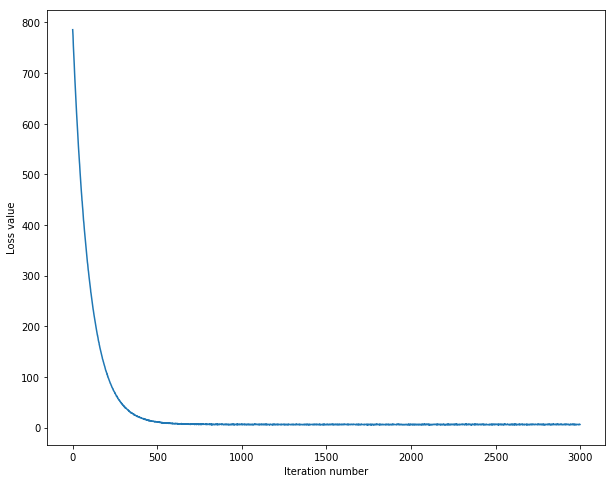

In [60]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [36]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.366163
validation accuracy: 0.380000


In [72]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7]
regularization_strengths = [7e3,7.5e3, 8e3, 8.5e3, 9e3, 9.5e3, 1e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

for i in learning_rates :
    for j in regularization_strengths :
        svm = LinearSVM()
        svm.train(X_train, y_train, learning_rate = i, reg = j, num_iters = 2000, batch_size = 200)
        y_train_pred = svm.predict(X_train)
        y_val_pred = svm.predict(X_val)
        results[(i,j)] = [np.mean(y_train == y_train_pred), np.mean(y_val == y_val_pred)]
        if np.mean(y_val == y_val_pred) > best_val :
            best_val = np.mean(y_val == y_val_pred)
            best_svm = svm
################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
pass
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-07 reg 7.000000e+03 train accuracy: 0.388571 val accuracy: 0.387000
lr 1.000000e-07 reg 7.500000e+03 train accuracy: 0.387469 val accuracy: 0.396000
lr 1.000000e-07 reg 8.000000e+03 train accuracy: 0.383755 val accuracy: 0.381000
lr 1.000000e-07 reg 8.500000e+03 train accuracy: 0.384551 val accuracy: 0.380000
lr 1.000000e-07 reg 9.000000e+03 train accuracy: 0.390102 val accuracy: 0.380000
lr 1.000000e-07 reg 9.500000e+03 train accuracy: 0.384776 val accuracy: 0.384000
lr 1.000000e-07 reg 1.000000e+04 train accuracy: 0.377980 val accuracy: 0.375000
best validation accuracy achieved during cross-validation: 0.396000


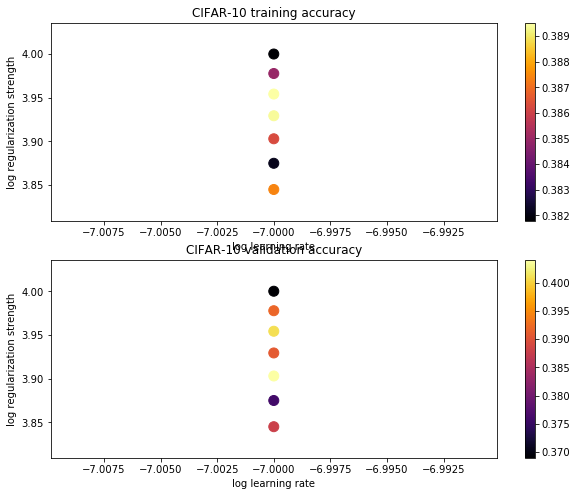

In [65]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap = "inferno")
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap = "inferno" )
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [73]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.388000


In [64]:
#test with batch_size
batch = [100,200,300,500,1000]

for i in batch : 
    tic = time.time()
    svm = LinearSVM()
    svm.train(X_train, y_train, learning_rate = 1e-7, reg = 8.5e3, num_iters = 1000, batch_size = i, verbose = 1)
    toc = time.time()
    y_test_pred = svm.predict(X_test)
    test_accuracy = np.mean(y_test == y_test_pred)
    print('linear SVM on raw pixels final test set accuracy: %f, time : %fs' % (test_accuracy,toc-tic))
    


iteration 0 / 1000: loss 285.052044
iteration 100 / 1000: loss 196.520090
iteration 200 / 1000: loss 141.197477
iteration 300 / 1000: loss 101.532851
iteration 400 / 1000: loss 72.582063
iteration 500 / 1000: loss 53.744011
iteration 600 / 1000: loss 39.184449
iteration 700 / 1000: loss 29.935820
iteration 800 / 1000: loss 22.389645
iteration 900 / 1000: loss 18.718553
linear SVM on raw pixels final test set accuracy: 0.373000, time : 2.604000s
iteration 0 / 1000: loss 288.131067
iteration 100 / 1000: loss 193.079429
iteration 200 / 1000: loss 138.667544
iteration 300 / 1000: loss 99.510565
iteration 400 / 1000: loss 73.353975
iteration 500 / 1000: loss 53.020146
iteration 600 / 1000: loss 39.459082
iteration 700 / 1000: loss 29.535988
iteration 800 / 1000: loss 22.577634
iteration 900 / 1000: loss 17.549569
linear SVM on raw pixels final test set accuracy: 0.355000, time : 4.940000s
iteration 0 / 1000: loss 285.750447
iteration 100 / 1000: loss 194.368093
iteration 200 / 1000: loss 13

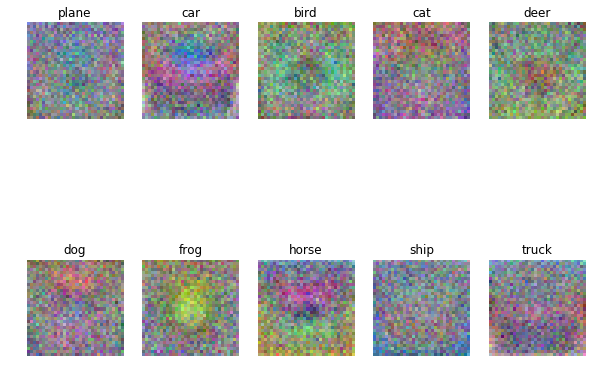

In [74]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *특정 지역에 유사한 weight가 존재함을 알 수 있다. (+ 대칭성)*